# All you need is love... and a good chemical affinity🧪❤️

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset, get_dataset2
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils
from sklearn.cluster import KMeans,SpectralClustering
from scikit_posthocs import posthoc_dunn
import os
import zipfile

#Imports to get rid of warnings
import warnings
from rdkit import RDLogger
import plotly.express as px
import scipy.stats as stats
RDLogger.DisableLog('rdApp.warning')
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

#Set a palette for all plots
sns.set_palette('Paired')


First of all, we can import the dataset with the ad-hoc function `get_dataset_complete`.

In [2]:
#Read the complete BindingDB dataset
df = get_dataset2()

#Plot the number of rows and columns in the dataset
print(f'BindingDB dataset rows: {df.shape[0]}')
print(f'BindingDB dataset columns: {df.shape[1]}')

BindingDB dataset rows: 2913040
BindingDB dataset columns: 194


The `BindingDB` dataset contains measured binding affinities between ligands (drugs) and protein targets in several organisms. Many affinity metrics are available, in particular $IC50$, $K_i$, $EC50$ and $K_d$, both from scientific literature and registered patents. Many experimental parameters are also available, such as the temperature and the pH at which the measurements were conducted. The `Target Source Organism According to Curator or DataSource` column contains the species (or type of living organism) that produces the target protein, being it an enzyme, receptor, etc. (this is instead contained in the `Target Name`) column. About the ligand, many representation formats are available, such as its SMILES string. For both the ligand and the target, IDs for locating them in different datasets (DrugBank, SwissProt) are available.  
To get a first intuition of which are such targets, we can visualize the target distirbution:

## Target organisms distribution

In [3]:
evaluation_utils.plot_target_organism_distribution_plotly(df)

We clearly observe that the most targeted organism is the human, indicating that many diseases are associated with human endogenous proteins. However, there is also a significant focus on other mammals, such as mice (`Mus musculus`) and rats (`Rattus`, `Rattus norvegicus`), and also a big spot is reserved for `Human immunodeficiency virus 1` (HIV1).  
Below we also plot the frequencies of the 20 most targeted organisms, to quantify this distribution:

In [4]:
most_targeted_organisms = df['Target Source Organism According to Curator or DataSource'].value_counts()[:20].reset_index()
most_targeted_organisms

,Target Source Organism According to Curator or DataSource,count
0,Homo sapiens,1541006
1,Rattus norvegicus,109758
2,Mus musculus,49854
3,Rattus,33713
4,Human immunodeficiency virus 1,21780
5,Bos taurus,17618
6,Electrophorus electricus,7921
7,Cavia porcellus,7639
8,Cavia cutleri,6540
9,Escherichia coli,5651


For our analysis we decided to focus on Sexually transmitted diseases, let's import the dataset and plot the relative distribution of these diseases, again using the column `Target Source Organism According to Curator or DataSource`.

In [2]:
df_std = get_dataset()
evaluation_utils.plot_target_organism_distribution_plotly(df_std)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

For our analysis, from the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs associated with `Human Immunodeficiency Virus 1 (HIV 1)`. Below we create it and plot its length:

In [3]:
hiv = df_std[df_std['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
print("Length of HIV dataset:", len(hiv))

Length of HIV dataset: 21780


In the dataset, four affinity metric are available:

1. **$K_i$ (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **$IC50$ (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **$K_d$ (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **$EC50$ (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between $K_i$ and $IC50$, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided. Below is a plot comparing the frequency of the metrics' presence and their relative overlapping:

In [4]:
evaluation_utils.plot_metric_availability_with_plotly(hiv)
evaluation_utils.plot_overlap_matrix_with_plotly(hiv)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

We observe that $IC50$ is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with $IC50$ for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.  
  
  
We also plot below the number of rows left after this operation:



In [5]:
hiv = data_utils.select_metric(hiv, 'IC50 (nM)')
hiv = data_utils.clean_na_columns(hiv)
print(f'Rows of STD dataset where IC50 is given: {hiv.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {hiv.shape[1]}')

Rows of STD dataset where IC50 is given: 13754
Columns of STD dataset where nan rows are less than 50% of the total: 27


# Focus on target proteins
Having selected the target organism, the Human Immunodeficiency Virus, we want now to study how we actually target it. We first focus on the target proteins in this virus:

In [7]:
evaluation_utils.plot_most_targeted_proteins_plotly(hiv)

We observe that many targets marked as different are just mutations or different sites of the same protein.  
To achieve a broader understanding, we decided to condense mutated proteins into the same category, and to not consider different sites on the same protein as different targets. Moreover, many proteins are just different conventional names for the same protein, and we accounted also for that. For instance, Reverse Transcriptase and Reverse Transcriptase/RNaseH were grouped under Reverse Transcriptase. This approach provides a generalized view while maintaining biological relevance.

In [6]:
hiv_condensed = evaluation_utils.group_similar_targets(hiv)

In [9]:
evaluation_utils.plot_most_targeted_proteins_plotly(hiv_condensed)

## Targeted HIV-1 Proteins

We clearly see that the most targeted proteins in HIV-1 are:

- **Reverse transcriptase**
- **Gag-Pol polyprotein**
- **Integrase**

Below is a brief description of these:

#### Reverse Transcriptase
Reverse transcriptase is an enzyme that plays a critical role in the HIV lifecycle by converting the virus's single-stranded RNA genome into double-stranded DNA once the virus enters a host cell. This conversion allows the viral DNA to integrate into the host’s genome, a necessary step for HIV replication.

Due to its essential function, reverse transcriptase is a major target for antiretroviral drugs. Two primary classes of inhibitors target this enzyme:
- **Nucleoside Reverse Transcriptase Inhibitors (NRTIs)**: These drugs mimic DNA building blocks, causing premature termination of the DNA chain and stopping HIV replication.
- **Non-Nucleoside Reverse Transcriptase Inhibitors (NNRTIs)**: These drugs bind directly to reverse transcriptase, blocking its activity by altering the enzyme's shape.

#### Gag-Pol Polyprotein
The Gag-Pol polyprotein is a precursor protein produced from the HIV genome that contains multiple essential viral components, including reverse transcriptase, protease, and integrase. During viral maturation, the Gag-Pol polyprotein is cleaved into its functional proteins by the **protease** enzyme, allowing the formation of mature, infectious viral particles.

**Protease inhibitors** are a class of antiretroviral drugs that specifically target the protease enzyme within the Gag-Pol polyprotein. By inhibiting protease, these drugs prevent the cleavage of Gag-Pol, halting the maturation of new viral particles and rendering them non-infectious.

#### Integrase
Integrase is another enzyme within the Gag-Pol polyprotein that facilitates the integration of HIV's DNA into the host cell's genome. This integration is a crucial step in establishing a permanent infection.   
**Integrase inhibitors** target this enzyme, blocking the integration process and thus preventing HIV from establishing a foothold within host cells.



To assess which protein targets are associated with the highest inhibitor affinity, we present the boxplots of the $IC50$ values for the most targeted HIV-1 proteins:

In [10]:
evaluation_utils.create_ic50_boxplot_plotly(hiv_condensed)

#### Check for differences in distribution

To statistically compare the IC50 values for the targeted proteins (`Gag-Pol polyprotein`, `Reverse transcriptase`, `Protein Rev`, and `Envelope glycoprotein gp160`), we initially considered using **ANOVA (Analysis of Variance)**.

ANOVA is used to test whether there are significant differences in the means of three or more groups. It operates under the following hypotheses:
- H0 (Null Hypothesis): The means of all groups are equal.
- H1 (Alternative Hypothesis): At least one group mean is different.

ANOVA assumes that the data in each group are normally distributed. To validate this assumption, we performed the *Kolmogorov-Smirnov* test for normality, as the dataset was too large to use the *Shapiro-Wilk* test. The *Kolmogorov-Smirnov* test evaluates whether the data conforms to a specified distribution, the normal in our case. The hypotheses for the test are:

- H0: The data follows a normal distribution.
- H1: The data does not follow a normal distribution.

In [11]:
evaluation_utils.perform_ks_test(hiv_condensed, group_col='Target Name', value_col='Log_IC50')

Gag-Pol polyprotein: KS-Test Statistic = 0.022772650435380515, p-value = 0.008943406243165808
Reverse transcriptase: KS-Test Statistic = 0.036299431501399027, p-value = 2.586002105175915e-07
Protein Rev: KS-Test Statistic = 0.13188194484492533, p-value = 0.18400160343832916
Envelope glycoprotein gp160: KS-Test Statistic = 0.11877823817476746, p-value = 0.0064662441313943966
Integrase: KS-Test Statistic = 0.09064312628998761, p-value = 9.603906015931026e-17


As shown in the results of the *Kolmogorov-Smirnov* test, not all distributions are normally distributed. Therefore, we will the *Kruskal-Wallis* test as a non-parametric alternative to ANOVA, and start considering the medians of the logarithmic $IC50$ instead of the means, since this metric is more robust to skewed distributions.

The *Kruskal-Wallis* Test is a rank-based test that does not assume normality. It evaluates whether the medians of two or more groups are significantly different. The hypotheses for the *Kruskal-Wallis* test are:

- H0 (Null Hypothesis): The distributions (and medians) of all groups are equal.
- H1 (Alternative Hypothesis): At least one group has a different median.

In [12]:
evaluation_utils.perform_kruskal_wallis_test(hiv_condensed, group_col='Target Name', value_col='Log_IC50')

Kruskal-Wallis Test: H-statistic = 2054.892714121525, p-value = 0.0
Significant differences found between groups.


We found that significant differences between the medians of the groups are present. We will now perform a post-hoc **Dunn's test**.

Dunn's test is a non-parametric post-hoc test used after a significant *Kruskal-Wallis* test to identify which specific groups differ in their medians. It performs pairwise comparisons between all groups and adjusts p-values to account for multiple testing.

- $H_0$: The medians of the two groups being compared are equal.
- $H_1$: The medians of the two groups being compared are different.


We found that significant differences between the medians of the groups are present. We will now 

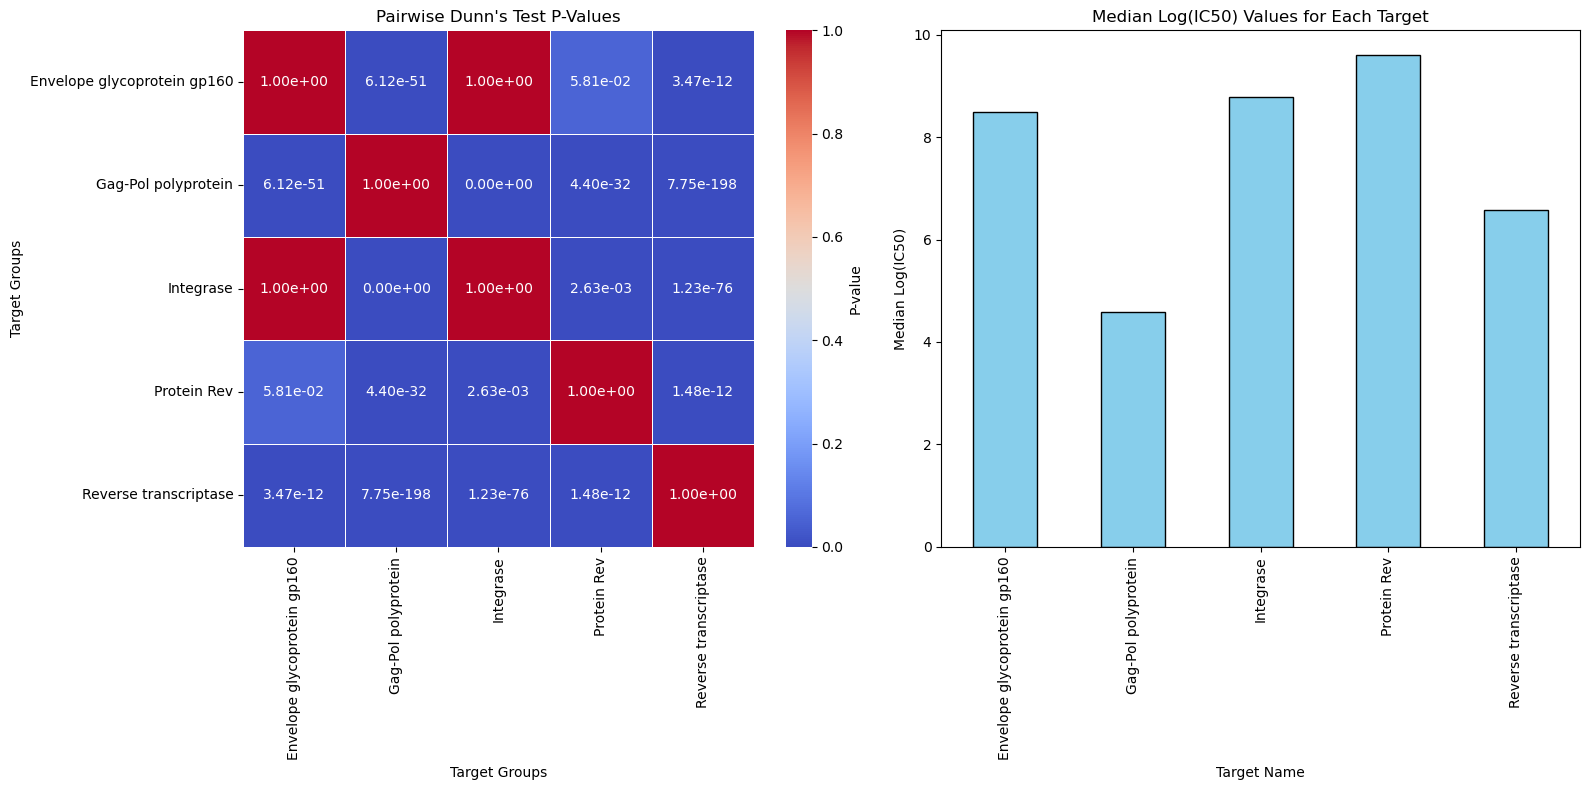

In [141]:
evaluation_utils.perform_posthoc_dunn_and_plot(
    hiv_condensed, 
    group_col='Target Name', 
    value_col='Log_IC50', 
    p_adjust_method='bonferroni'
)


From the results of the pairwise Dunn's test (left plot), we observe that between the Gag-Pol polyprotein and other targets the p-values are extremely small, with the largest one being `4.40e-32`. This implies that, at the standard significance level of 0.05, Gag-Pol polyprotein median logarithmic $IC50$ is **significantly different** from the other groups. By looking at the median $IC50$ values for the groups (right plot), we observe that Gag-Pol polyprotein's one is **lower** than those for other groups.  

These results suggest that Gag-Pol polyprotein has a **significantly better binding affinity** than other targets from HIV-1, indicating that it may be the most sensitive target in the figth against the virus. 

**But a couple is composed of two parts, so let's focus on the ligands:**


## Focus on Ligands
In the previous sections we found out how Gag-Pol seems to be the target that offers the highest affinity. Now we would like to explore the ligands that target it and see what are the characteristics that make them more powerful. In order to so we need a way to extract molecular features, we do so through RDKIT expansion library.

### RDKit expansion ###

First of all, we create a copy of the Gag-Pol dataframe and we perform some general cleaning.

In [12]:
hivRD = hiv_condensed.copy()
hivRD = data_utils.nan_to_numeric(hivRD)

We created the following functions: smiles_to_mol, calculate_descriptors, .
These functions compute:
- 'smiles_to_mol': creates rdkit mol object from SMILES string
- 'calculate_descriptors': creates a dataframe with 12 features from the molecule

With the data ready, we can use the first function to get the 'mol' rdkit object from the molecule SMILES.

In [13]:
# Convert SMILES to RDKit Mol objects
hivRD['Mol'] = hivRD['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)

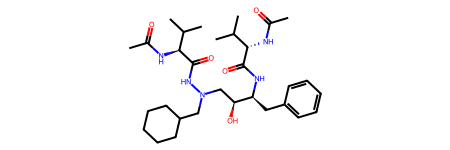

In [14]:
#try to print the first one, for seek of visualization
hivRD['Mol'][0]

Now we can compute all molecular descriptors starting from the 'Mol' column. Some of the chosen descriptors are:
- *MolWt*: The molecular weight of the molecule, calculated as the sum of the atomic weights of all atoms present.
- *LogP*: The octanol-water partition coefficient (Log P), indicating the molecule's lipophilicity or hydrophobicity.
- *NumHDonors*: Number of hydrogen bond donors, typically counting hydrogen atoms attached to oxygen or nitrogen.
- *NumHAcceptors*: Number of hydrogen bond acceptors, such as oxygen or nitrogen atoms with lone pairs.
- *TPSA*: Topological Polar Surface Area, representing the surface area occupied by polar atoms; useful for predicting drug absorption.
- *NumRotatableBonds*: Number of rotatable bonds, affecting the molecule's flexibility.
- *NumAromaticRings*: Number of aromatic rings within the molecule.
- *NumAliphaticRings*: Number of aliphatic (non-aromatic) rings in the molecule.
- *FractionCSP3*: Fraction of sp³-hybridized carbons over total carbons, indicating the molecule's saturation level.
- *RingCount*: Total number of rings, both aromatic and aliphatic, present in the molecule.
- *FormalCharge*: The net formal charge of the molecule, calculated based on its electron configuration.
- *NumRadicalElectrons*: Number of unpaired (radical) electrons in the molecule.

In [156]:
# Calculate descriptors and add them to the DataFrame
descriptor_df = hivRD['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD = pd.concat([hivRD, descriptor_df], axis=1)

Separe now numerical and non numerical features to perform any numerical or statistical analysis. The numerical dataframe is then standardized and the radical electrons column is dropped since is containing all zeros

In [16]:
numerical_df, non_numerical_df = data_utils.separe_num_df(hivRD)
numerical_df = (numerical_df - numerical_df.min())/(numerical_df.max() - numerical_df.min())
numerical_df = numerical_df.drop(columns=['NumRadicalElectrons']) #column dropped as it was all 0-valued

### PCA Analysis ###

Before trying PCA and other further analysis we started from more basic analysis. Specifically, we inspected the presence of any possible linear or non-linear correlation between each feature and IC50, and also between features (see 'linearity-tests.ipynb' in 'tests' folders). Only after seeing the absence of these, we proceeded to apply more advanced analysis, starting from PCA.

The purpose of applying PCA is to assess the single features contribuition to each principal component, to understand which of them are possibly more 'meaningful'. We start by dropping some columns that can't be used to perform PCA.

In [32]:
numerical_df_pca= numerical_df.drop(columns=['Log_IC50','index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID', 'IC50 (nM)', 'Number of Protein Chains in Target (>1 implies a multichain complex)'])

Then, we initialize PCA fixing the desired cumulative explained variance to 0.9, to be sure to keep enough information from the original data. Then, we extract each PCA Component to assess single features contribuitions (i.e. the weights assigned to each feature to obtain that principal component), saving everything in the 'loadings_df' dataframe.

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(numerical_df_pca) #run PCA

components = pca.components_
feature_names = numerical_df_pca.columns
loadings_df = pd.DataFrame(components, columns=feature_names, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']) #get coefficients

To really understand features contribuitions we sum each feature weight for each principal component, ensuring soundness by:
- using their absolute values;
- weighting each term by the correspondent principal component explained variance (because not all components have the same importance).

In [168]:
explained_variance = pca.explained_variance_ratio_
loadings_df_absv = loadings_df.apply(np.abs)
loadings_df_absv_contr = loadings_df_absv.T['PC1'] * explained_variance[0] + loadings_df_absv.T['PC2'] * explained_variance[1] + loadings_df_absv.T['PC3'] * explained_variance[2] + loadings_df_absv.T['PC4'] * explained_variance[3] + loadings_df_absv.T['PC5'] * explained_variance[4]
loadings_df_absv_contr.sort_values()

FormalCharge                       0.012580
NumBridgeheadAtoms                 0.014136
NumSpiroAtoms                      0.045956
LogP                               0.047563
NumSaturatedCarbocycles            0.057177
NumUnspecifiedAtomStereoCenters    0.063349
BertzCT                            0.067763
RingCount                          0.070503
NumAromaticRings                   0.076989
TPSA                               0.088349
NumHDonors                         0.089941
NumSaturatedHeterocycles           0.090133
NumRotatableBonds                  0.099869
MolMR                              0.101886
NumHAcceptors                      0.103717
Chi1n                              0.104486
MolWt                              0.105873
Chi1v                              0.107659
Chi0v                              0.110365
Chi0n                              0.110609
NumSaturatedRings                  0.122704
NumAtomStereoCenters               0.144607
NumAliphaticRings               

We can notice that the fraction of total SP3 hybridized carbons plays an important role in the determination of principal components, followed by the Balaban's J index and the number of Aliphatic Rings in the molecule. A first naive analysis can consist in seeing if binding affinity changes for different values of these features, specifically of the most important one. 
To do so, we first extract the column and inspect it by visualizing its histogram.

[]

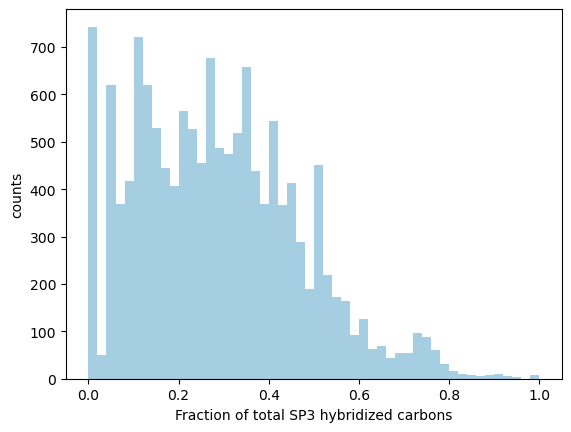

In [174]:
frc = numerical_df_pca['FractionCSP3'].values
plt.hist(frc, bins=50)
plt.xlabel('Fraction of total SP3 hybridized carbons')
plt.ylabel('counts')
plt.plot()

The distribution is quite left-skewed. We can inspect binding affinity grouping ligands by different values of the feature. To do so we use first and third quartiles as grouping rule.

In [229]:
q1, q3 = np.quantile(frc, [0.25, 0.75])
numerical_df_pca['frc_class'] = 1  # Initialize all values to 2
numerical_df_pca.loc[numerical_df_pca['FractionCSP3'] < q1, 'frc_class'] = 0  # Assign 0 where CSP3 < q1
numerical_df_pca.loc[numerical_df_pca['FractionCSP3'] > q3, 'frc_class'] = 2  # Assign 1 where CSP3 > q3

We then recover the IC50 column (dropped to ensure ground PCA results), and inspecpt its boxplots for the three groups.

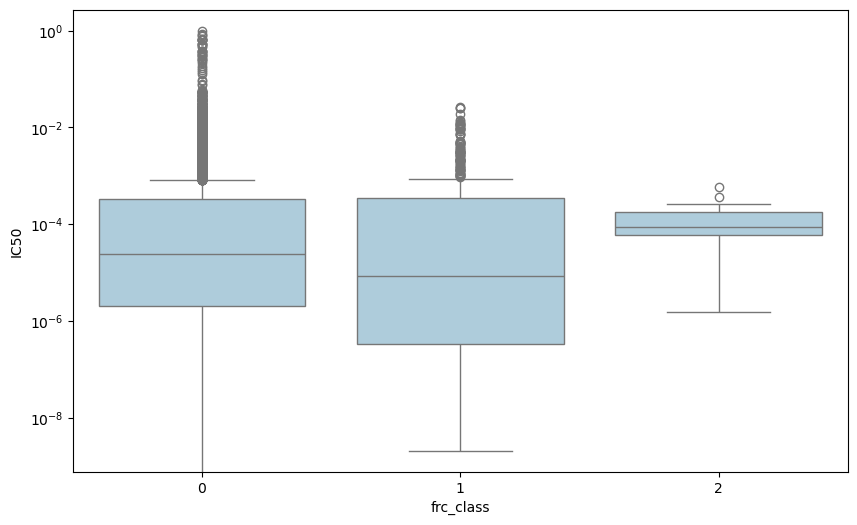

In [178]:
numerical_df_pca['IC50'] = numerical_df['IC50 (nM)'].values
plt.figure(figsize=(10, 6))
sns.boxplot(x ='frc_class', y='IC50', data = numerical_df_pca)
plt.yscale('log')

We can see that the boxplots seem to be overlapped, but also that groups 0 and 1 ones (which correspond to 0-25 and 25-75 quartiles) present many points out of bounds. To better exploit a possible difference bewteen such groups, we can use statistical tests. First, we use again the Kolmogorov-Smirnov test to see if data are normally distributed.

In [180]:
evaluation_utils.perform_ks_test(numerical_df_pca, group_col='frc_class', value_col='IC50')

0: KS-Test Statistic = 0.4673458072352076, p-value = 0.0
1: KS-Test Statistic = 0.3732955338231151, p-value = 6.206654547561055e-66
2: KS-Test Statistic = 0.25574586504360464, p-value = 0.20706940423016684


From the results we can see that the third gruop is likely normally distributed, but the others two are not. For this reason to compare such groups we can use again the Kruskal Wallis test.

In [181]:
evaluation_utils.perform_kruskal_wallis_test(numerical_df_pca, group_col='frc_class', value_col='IC50')

Kruskal-Wallis Test: H-statistic = 25.47910619465856, p-value = 2.932799596832971e-06
Significant differences found between groups.


To get every inter group differencies, we can also plot the Dunn's test results.

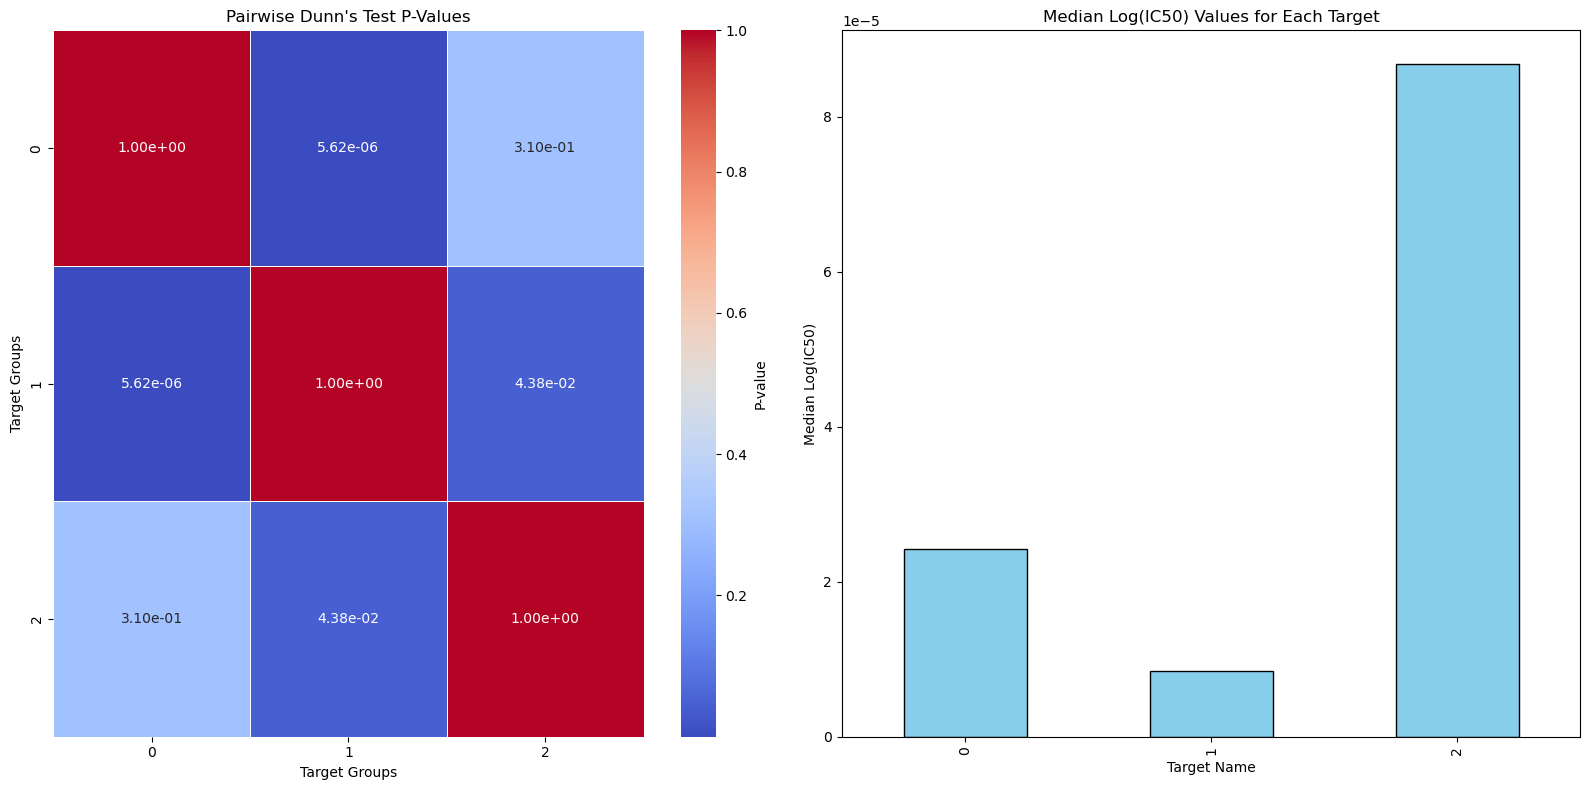

In [182]:
evaluation_utils.perform_posthoc_dunn_and_plot(
    numerical_df_pca, 
    group_col='frc_class', 
    value_col='IC50', 
    p_adjust_method='bonferroni'
)

From the test reuslt, it seems that having  an intermediate number of hybridized sp3 carbons leads to better binding affininty in ligands targeting Gag-Polyprotein, while too many or too few ones lead to worse binding affinity. This seems to be an interesting correlation, with a feature that is directly linked to binding affinity in a specific subgroup of HIV1 ligands. It is still important to remark that this is a naive finding, possibly hiding confounders and most probably more complex patterns. This is valid both to assess IC50 value and the 'Goodness' of a drug, which surely doesn't depend solely on the lattest, but is probably influenced by other multiple factors.

Still, we can visualize an example molecule for each of these three groups, to have a graphical correspondence with the feature and to assess the different drugs linked to them. To do so, we put the carbon crafted class in the non numerical dataframe, containing SMILES and Mol objects, then we filter them by their class membership.

In [235]:
non_numerical_df['frc_class'] = numerical_df_pca['frc_class'].values
frc0 = non_numerical_df[non_numerical_df['frc_class'] == 0]
frc1 = non_numerical_df[non_numerical_df['frc_class'] == 1]
frc2 = non_numerical_df[non_numerical_df['frc_class'] == 2]

Now we can visualize such molecules, starting from one with low number of CSP3.

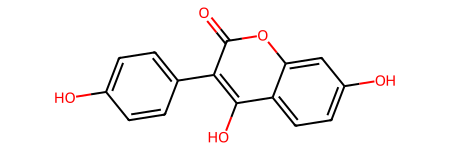

In [284]:
frc0['Mol'][13739]

Then one with an average numer

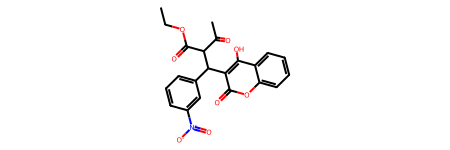

In [285]:
frc1['Mol'][13740]

And finally a third with high number.

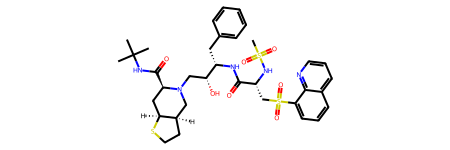

In [281]:
frc2['Mol'][365]

But now the question is, what can we get from this?  
A first thing that we can notice is that it seems that molecules with more hybridized sp3 carbons exhibit a more complex structure, as each carbon they have can bind four other atoms. Indeed another insteresting fact is that most of commercialized drugs against HIV-1 that targret the Gag-pol Polyprotein have a high number of CSP3 (some examples are Darunavir, whose molecular structure is shown just above, Tipranavir, Saquinavir, Amprenavir and Lopinavir). This can be because a more complex structure results in higher molecular flexibility, particularly useful to catch complex interactions with dynamic binding sites, and in this case binding affinity isn't the most important factor to be considered. Furthermore, molecules with less hybridized CSP3 , for example the first two shown (the first one is known as S-1360 compound, among the early integrase inhibitors studied for HIV therapy, and the second represents another similar compound) were used in attempted trials but never commercialized, suggesting that the low (or average) number of CSP3 can improve binding affinity thanks to the more planar molecular structure, but this is not necessarily related to the overall success of the drug! The conclusion that arises from this analysis is that, despite the meaningful statistical differencies in binding affinities between the three groups, as also said before binding affinity is just a 'little' piece of a way more complex puzzle. Still, it's interesting to observe that the CSP3-based division has other explainations out of the possible association with different IC50 values.